In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/sample_20210509.sqlite")

In [98]:
df = pd.read_sql_query("""
    -- cohorts are people who started in the same month
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of month") as starting_month
        from levels
        where level = 2
        group by 1
    ),
    -- we'll only look at n days after people start playing
    day_range as (
            select 0 day 
        union 
            select day + 1 
            from day_range 
            where day <= 90
    ),
    selected_cohort as (
        select distinct
            starting_month,
            name,
            cast(julianday(timestamp)-julianday(starting_ts) as integer) as difference,
            level
        from levels
        join cohort
        using (name)
    ),
    -- many players will level more than once in a day, so choose the level on the day boundary
    level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) over (
                partition by starting_month, name
                order by level
                rows 1 preceding
            ) as level
        from day_range
        cross join selected_cohort
        where difference <= day
            and starting_month < "2021-01-01"
    ),
    -- get the max level for each day, this one in particularly interesting for other analysis
    max_level_at_day as (
        select
            starting_month,
            name,
            day,
            max(level) as level
        from level_at_day
        group by 1, 2, 3
    )
    select
        *
    from
        max_level_at_day
""", conn)
df

,starting_month,name,day,level
0,2015-10-01,Maccabi,0,6
1,2015-10-01,Maccabi,1,6
2,2015-10-01,Maccabi,2,6
3,2015-10-01,Maccabi,3,6
4,2015-10-01,Maccabi,4,6
...,...,...,...,...
79851,2020-12-01,trevernation,87,22
79852,2020-12-01,trevernation,88,22
79853,2020-12-01,trevernation,89,22
79854,2020-12-01,trevernation,90,22


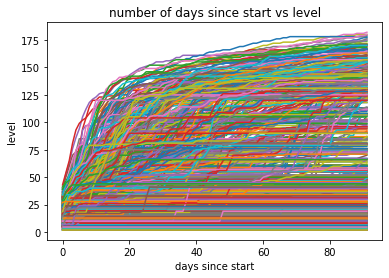

In [105]:
for name in pd.Series(df.name.unique()):
    s = df[df.name == name]
    plt.plot(s.day, s.level)
plt.title("number of days since start vs level")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()

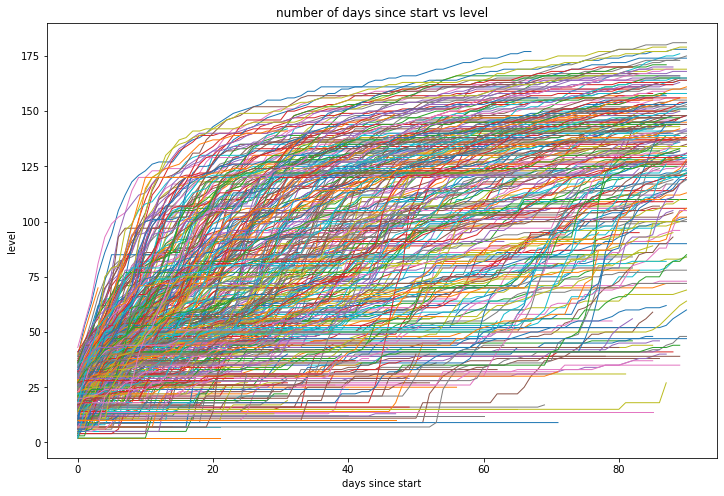

In [182]:
plt.figure(figsize=(12,8))

for name in pd.Series(df.name.unique()):
    s = df[df.name == name]
    s = df[df.name == name].sort_values("day").reset_index()
    diffs = s.level.diff()
    indices = s[diffs > 0]
    if not len(indices):
        continue
    s = s[s.index < indices.index[-1]]
    plt.plot(s.day, s.level, linewidth=1)

plt.title("number of days since start vs level")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()

In [186]:
pd.read_sql_query("""
    with cohort as (
        select name, date(min(timestamp), "start of year") as starting_year
        from levels
        group by 1
    )
    select starting_year, count(distinct name)
    from cohort
    group by 1
    order by 1
""", conn)

,starting_year,count(distinct name)
0,2015-01-01,37
1,2016-01-01,47
2,2017-01-01,246
3,2018-01-01,136
4,2019-01-01,125
5,2020-01-01,307
6,2021-01-01,102


In [204]:
df = pd.read_sql_query("""
    -- cohorts are people who started in the same month
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of year") as starting_year
        from levels
        where level = 2
        group by 1
    ),
    -- we'll only look at n days after people start playing
    day_range as (
            select 0 day 
        union 
            select day + 1 
            from day_range 
            where day <= 90
    ),
    selected_cohort as (
        select distinct
            starting_year,
            name,
            cast(julianday(timestamp)-julianday(starting_ts) as integer) as difference,
            level
        from levels
        join cohort
        using (name)
        where starting_year >= "2016-01-01" and starting_year < "2021-01-01"
    ),
    -- many players will level more than once in a day, so choose the level on the day boundary
    level_at_day as (
        select
            starting_year,
            name,
            day,
            max(level) over (
                partition by starting_year, name
                order by level
                rows 1 preceding
            ) as level
        from day_range
        cross join selected_cohort
        where difference <= day
    ),
    -- get the max level for each day, this one in particularly interesting for other analysis
    max_level_at_day as (
        select
            starting_year,
            name,
            day,
            max(level) as level
        from level_at_day
        group by 1, 2, 3
    )
    select 
        starting_year,
        day,
        count(distinct name) as cohort_size,
        sum(level) as sum_level,
        avg(level) as avg_level
    from max_level_at_day
    group by 1, 2
    order by 1, 2
""", conn)
df

,starting_year,day,cohort_size,sum_level,avg_level
0,2016-01-01,0,45,691,15.355556
1,2016-01-01,1,45,862,19.155556
2,2016-01-01,2,45,940,20.888889
3,2016-01-01,3,45,999,22.200000
4,2016-01-01,4,45,1034,22.977778
...,...,...,...,...,...
455,2020-01-01,87,307,19956,65.003257
456,2020-01-01,88,307,19986,65.100977
457,2020-01-01,89,307,20031,65.247557
458,2020-01-01,90,307,20075,65.390879


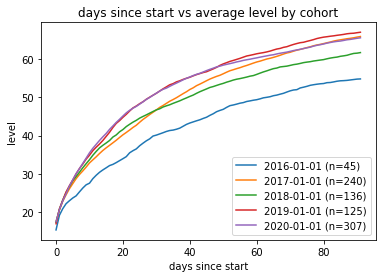

In [205]:
for year in df.starting_year.unique():
    s = df[df.starting_year == year]
    n = s.cohort_size.min()
    plt.plot(s.day, s.avg_level, label=f"{year} (n={n})")
plt.legend()
plt.title("days since start vs average level by cohort")
plt.xlabel("days since start")
plt.ylabel("level")
plt.show()

In [206]:
df = pd.read_sql_query("""
    -- cohorts are people who started in the same month
    with cohort as (
        select
            name,
            min(timestamp) as starting_ts,
            date(min(timestamp), "start of year") as starting_year
        from levels
        where level = 2
        group by 1
    ),
    -- we'll only look at n days after people start playing
    day_range as (
            select 0 day 
        union 
            select day + 1 
            from day_range 
            where day <= 90
    ),
    selected_cohort as (
        select distinct
            starting_year,
            name,
            cast(julianday(timestamp)-julianday(starting_ts) as integer) as difference,
            level
        from levels
        join cohort
        using (name)
        where starting_year >= "2016-01-01" and starting_year < "2021-01-01"
    ),
    -- many players will level more than once in a day, so choose the level on the day boundary
    level_at_day as (
        select
            starting_year,
            name,
            day,
            max(level) over (
                partition by starting_year, name
                order by level
                rows 1 preceding
            ) as level
        from day_range
        cross join selected_cohort
        where difference <= day
    ),
    -- get the max level for each day, this one in particularly interesting for other analysis
    max_level_at_day as (
        select
            starting_year,
            name,
            day,
            max(level) as level
        from level_at_day
        group by 1, 2, 3
    )
    select 
        *
    from max_level_at_day
    where day in (30, 60, 90)
""", conn)
df

,starting_year,name,day,level
0,2016-01-01,1stTimeMaple,30,10
1,2016-01-01,1stTimeMaple,60,10
2,2016-01-01,1stTimeMaple,90,10
3,2016-01-01,Abby,30,81
4,2016-01-01,Abby,60,124
...,...,...,...,...
2554,2020-01-01,xfce,60,82
2555,2020-01-01,xfce,90,113
2556,2020-01-01,zenq,30,15
2557,2020-01-01,zenq,60,15


<AxesSubplot:title={'center':'level'}, xlabel='starting_year'>

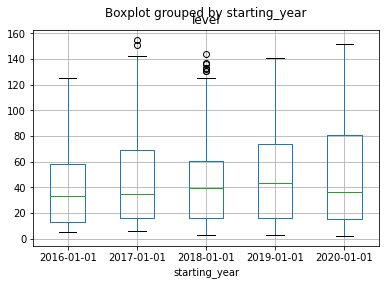

In [209]:
df[df.day == 30].boxplot(column="level", by="starting_year")

<AxesSubplot:title={'center':'level'}, xlabel='starting_year'>

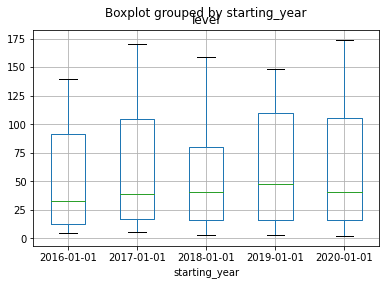

In [210]:
df[df.day == 60].boxplot(column="level", by="starting_year")

<AxesSubplot:title={'center':'level'}, xlabel='starting_year'>

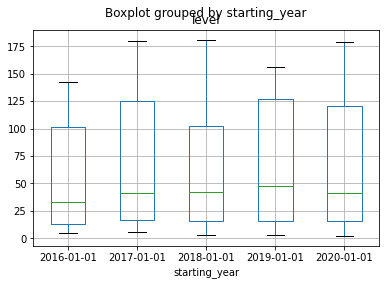

In [211]:
df[df.day == 90].boxplot(column="level", by="starting_year")